# System Demo

## Imports

In [1]:
import torch
import pandas as pd
from project.dataset import VALDODataset
from torch.utils.data import DataLoader
from project.preprocessing import NiftiToTensorTransform, get_transform
from project.utils import collatev2
from project.utils import compute_statistics
from project.model import RPN, ISAVIT, Feeder
import random
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.model_selection import train_test_split
import matplotlib.patches as patches

## Config Initialization

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### ISA-RPN configs

In [3]:
image_size = 300
patch_size = 32

In [4]:
rpn = RPN(
        input_dim=512,
        output_dim=4,
        image_size=image_size,
        global_context=True,
        nh=4,
        pretrained=False
    ).to(device)

324


c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


### Feeder

In [5]:
resize = get_transform(
    height=patch_size,
    width=patch_size,
    p=1.0,
    rpn_mode=False
)

feeder = Feeder(resize)

### ISA-ViT configs

In [6]:
vit = ISAVIT(
        d_model=512,
        patch_size=32,
        dim_ff=1600,
        global_context=True,
        patchpatch_size=16,
        n_layers=12
    ).to(device)

### Load Weights

In [7]:
rpn.load_state_dict(torch.load('best_fold_weights/isa-rpn/LATEST_rpn_fold2.pt'))

<All keys matched successfully>

In [8]:
vit.load_state_dict(torch.load('best_fold_weights/isa-rpn_isa-vit/ISARPN_ISAVIT_fold4.pt'))

<All keys matched successfully>

## Dataset Loading

In [9]:
data = pd.read_csv('targets.csv')
data.shape

(7986, 9)

### Target slices that have cmbs

In [10]:
positive_data = data.query('has_microbleed_slice == 1').reset_index(drop=True)
positive_data.shape

(364, 9)

In [11]:
test_size=0.2
random_state=12

In [12]:
positive_cohort_1 = positive_data.query('cohort == 1').reset_index(drop=True)

_, positive_cohort_1 = train_test_split(
    positive_cohort_1,
    test_size=test_size,
    random_state=random_state
)

positive_cohort_1 = positive_cohort_1.reset_index(drop=True)

positive_cohort_1.shape

(9, 9)

In [13]:
positive_cohort_3 = positive_data.query('cohort == 3').reset_index(drop=True)

_, positive_cohort_3 = train_test_split(
    positive_cohort_3,
    test_size=test_size,
    random_state=random_state
)

positive_cohort_3 = positive_cohort_3.reset_index(drop=True)

positive_cohort_3.shape

(10, 9)

#### Test Case for Cohort 1

In [14]:
# random number ranging from 1 to shape of positive data in cohort 1 and skip 3 numbers before selecting
rand_num = random.randrange(1, positive_cohort_1.shape[0], 3)

test_case_1 = positive_cohort_1.loc[rand_num]

rand_num2 = random.randrange(1, positive_cohort_1.shape[0], 3)
while rand_num2 == rand_num:
    rand_num2 = random.randrange(1, positive_cohort_1.shape[0], 3)

test_case_2 = positive_cohort_1.loc[rand_num2]

#### Test Case for Cohort 3

In [15]:
# random number ranging from 1 to shape of positive data in cohort 3 and skip 3 numbers before selecting
rand_num = random.randrange(1, positive_cohort_3.shape[0], 3)
test_case_3 = positive_cohort_3.loc[rand_num]

rand_num2 = random.randrange(1, positive_cohort_3.shape[0], 3)
while rand_num2 == rand_num:
    rand_num2 = random.randrange(1, positive_cohort_3.shape[0], 3)

test_case_4 = positive_cohort_3.loc[rand_num2]

## Test Cases Combined

### DataFrame of Test Cases

In [16]:
test_cases = [test_case_1, test_case_2, test_case_3, test_case_4]

test_cases = pd.DataFrame(test_cases)
test_cases = test_cases.reset_index(drop=True)
test_cases

mri  \
0  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...   
1  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...   
2  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...   
3  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...   

                                               masks  \
0  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...   
1  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...   
2  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...   
3  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...   

                                            stripped  target  \
0  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...      24   
1  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...       9   
2  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...      26   
3  c:\Users\Lex Zedrick Lorenzo\Documents\GitHub\...      23   

   has_microbleed_case  has_microbleed_slice  cohort   max_value  slices  
0                    1                     1       1  1011.27124      35  
1                    1                     1       1   954.49292      35  
2                    1                     1       3   241.00000      36  
3                    1                     1       3   293.00000      39

In [17]:
from sklearn.model_selection import train_test_split

def make_dataset(data,
                 cohort,
                 skull_stripped,
                 target_shape=(300, 300),
                ):
    data = data[data.cohort == cohort]
    
    s = f'Creating dataset for Cohort {cohort}\n'

    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'

    transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=False,
        normalization=(global_min, global_max)
    )

    if skull_stripped == True:
        dataset = VALDODataset(
            cases=data.stripped.tolist(),
            masks=data.masks.tolist(),
            target=data.target.tolist(),
            transform=transform
        )
    else:
        dataset = VALDODataset(
            cases=data.mri.tolist(),
            masks=data.masks.tolist(),
            target=data.target.tolist(),
            transform=transform
        )
    return dataset

### Dataset made of Raw MRI

In [18]:
raw_dataset_cohort1 = make_dataset(data=test_cases, cohort=1, skull_stripped=False)
raw_dataset_cohort3 = make_dataset(data=test_cases, cohort=3, skull_stripped=False)

test_cases_dataset_raw = ConcatDataset([raw_dataset_cohort1, raw_dataset_cohort3])
test_cases_dataset_raw_dl = DataLoader(
    test_cases_dataset_raw,
    shuffle=False,
    batch_size=test_cases_dataset_raw.__len__(),
    collate_fn=collatev2
)

### Dataset made of Skull-stripped MRI

In [19]:
stripped_dataset_cohort1 = make_dataset(data=test_cases, cohort=1, skull_stripped=True)
stripped_dataset_cohort3 = make_dataset(data=test_cases, cohort=3, skull_stripped=True)

test_cases_dataset_stripped = ConcatDataset([stripped_dataset_cohort1, stripped_dataset_cohort3])
test_cases_dataset_stripped_dl = DataLoader(
    test_cases_dataset_stripped,
    shuffle=False,
    batch_size=test_cases_dataset_stripped.__len__(),
    collate_fn=collatev2
)

### Feedset for bounding box comparison

In [20]:
def make_feedset(
        data,
        target_shape=(300, 300),
        rpn_mode=True,
        logger=None
    ):
    s = f'Creating feedset\n'
    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'
    global_min, global_max = compute_statistics(paths)
    
    feedset_transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )
    feedset = VALDODataset(
    cases=data.stripped,
    masks=data.masks,
    target=data.target,
    transform=feedset_transform
    )
    print(s)
    return feedset

In [21]:
feedset = make_feedset(
    data=data,
    rpn_mode=True,
    target_shape=(300, 300)
)

Creating feedset
Total Unique MRI Samples in data_train: 72
GLOBAL MIN & MAX (0.0, 87519.8515625)



## Prediction using the model

In [22]:
from torchmetrics.functional.detection import intersection_over_union
def predict(loader, stage1, stage2, feeder):
    Y = []
    T = []
    cases = []
    targets = []
    bbox_predictions = []
    with torch.inference_mode():
        for batch in loader:
            for slices, masks, target, case in batch:
                slices = slices.squeeze(1).float().to(device)
                masks = masks.float().to(device)
                bbox = stage1(slices, target)
                bbox = bbox * image_size

                regions = feedset.locate_case_by_mri(case)
                bboxes = regions[1].view(regions[1].shape[0], -1)
                gt_bbox = bboxes[target].int().tolist()

                gt_bbox = torch.Tensor([gt_bbox])
        
                iou_score = intersection_over_union(bbox.detach().cpu(), gt_bbox)
                if iou_score < 0.5:
                    print(f'Whole MRI. IOU:{iou_score}')
                    x = masks
                    t = masks
                else:
                    print(f'Cropped MRI. IOU:{iou_score}')
                    bbox = bbox.squeeze().round().int().detach().cpu().numpy()
                    x = feeder(slices, bbox, 32)
                    t = feeder(masks, bbox, 32)

                x = x.flatten(2).float().to(device)
                t = t.flatten(2).float().to(device)
                segmented_mask = stage2(x, target)

                Y.append(segmented_mask)
                T.append(t[target])
                cases.append(case)
                targets.append(target)
                bbox_predictions.append(bbox)

    return Y, T, cases, targets, bbox_predictions

In [23]:
predictions, ground_truths, cases, targets, bbox_predictions = predict(
    loader=test_cases_dataset_stripped_dl,
    stage1=rpn,
    stage2=vit,
    feeder=feeder
)

c:\Users\Lex Zedrick Lorenzo\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Whole MRI. IOU:0.19268177449703217
Whole MRI. IOU:0.005841883365064859
Whole MRI. IOU:0.2584579586982727
Cropped MRI. IOU:0.5716583132743835


## Visualizations

### Before Normalization and Resize

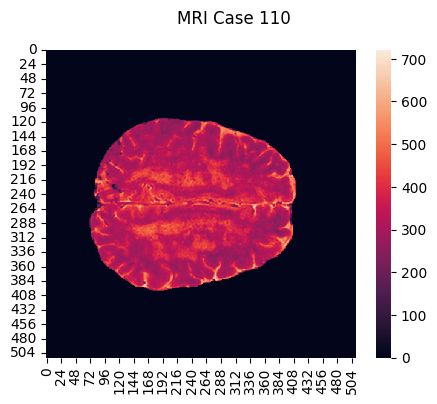

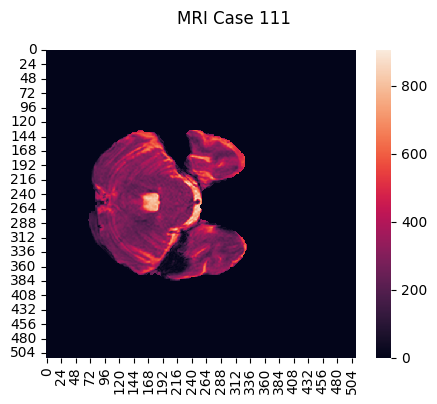

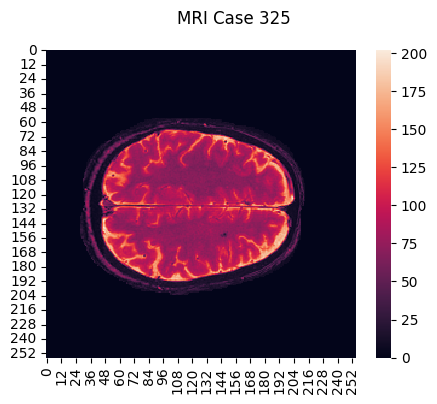

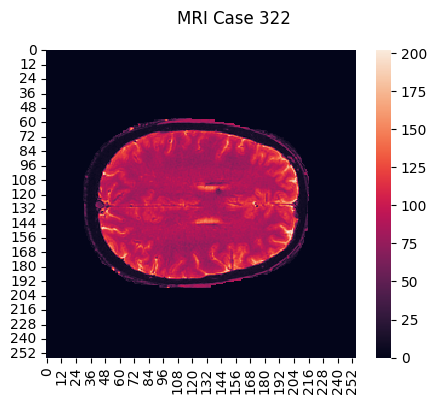

In [24]:
import nibabel as nib
import numpy as np
for i in range(test_cases.shape[0]):
    mri = nib.load(test_cases['mri'].loc[i]).get_fdata()
    mri = np.transpose(mri, (2, 0, 1))
    slice_index = test_cases['target'].loc[i]
    mri_slice = mri[slice_index]

    f, a = plt.subplots(1, 1, figsize=(5, 4))
    f.suptitle(f"MRI Case {test_cases['mri'].loc[i].split('\\')[-1].split('_')[0][-3:]}")
    sns.heatmap(mri_slice, ax=a, vmax=np.max(mri_slice))
    plt.show()

### Raw MRI and Target Slice Visualization

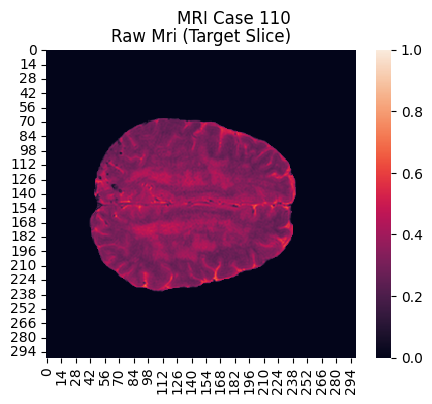

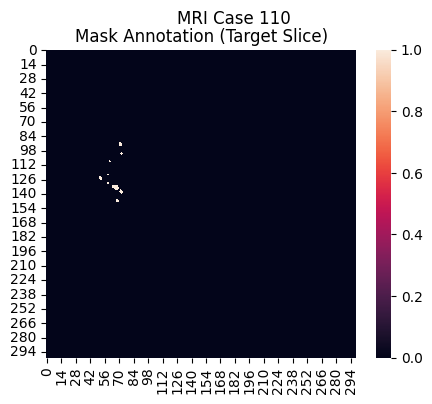

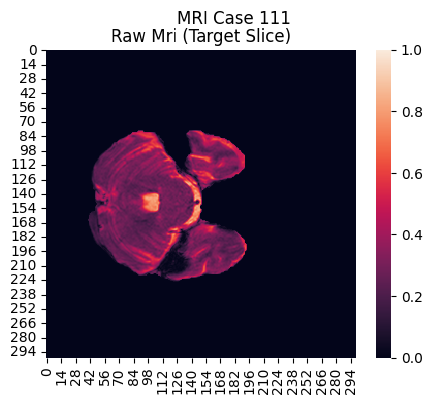

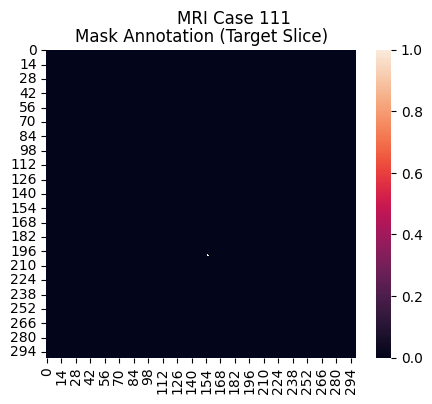

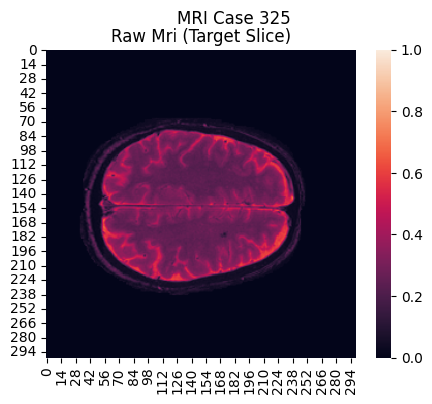

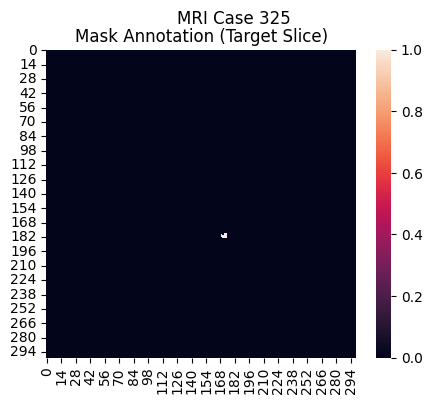

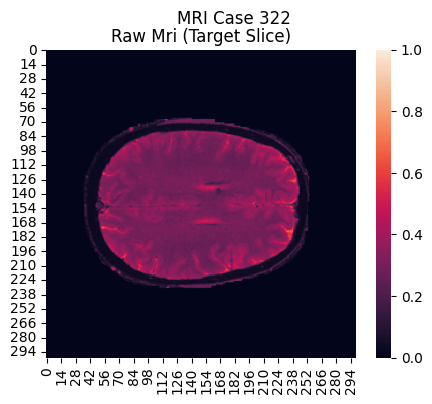

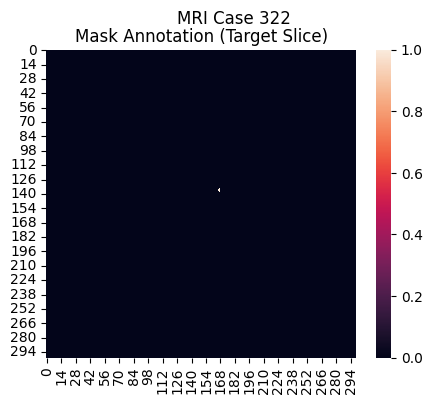

In [25]:
for batch in test_cases_dataset_raw_dl:
    for slices, masks, target, case in batch:
        f, a = plt.subplots(1, 1, figsize=(5, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Raw Mri (Target Slice)')
        sns.heatmap(slices[target].squeeze(), ax=a, vmax=1)

        f, a = plt.subplots(1, 1, figsize=(5, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Mask Annotation (Target Slice)')
        sns.heatmap(masks[target].squeeze(), ax=a, vmax=1)

### Skull-stripped MRI and Target Slice Visualization

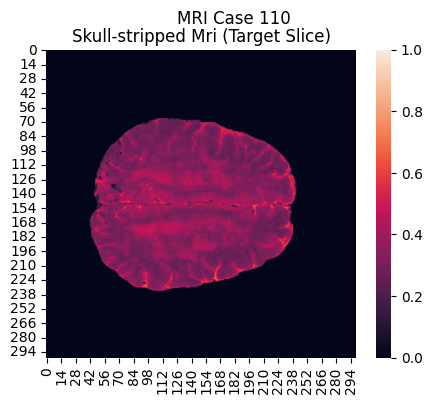

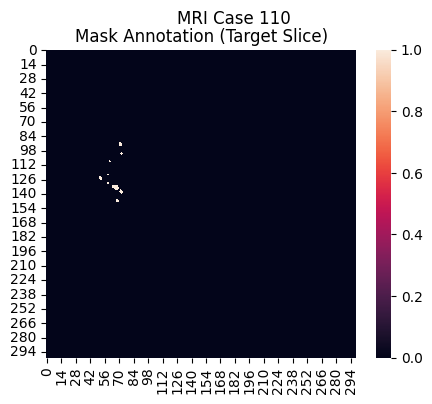

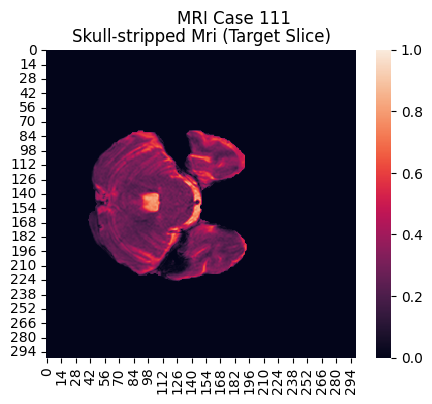

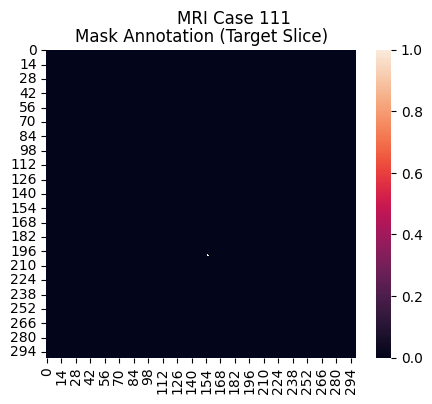

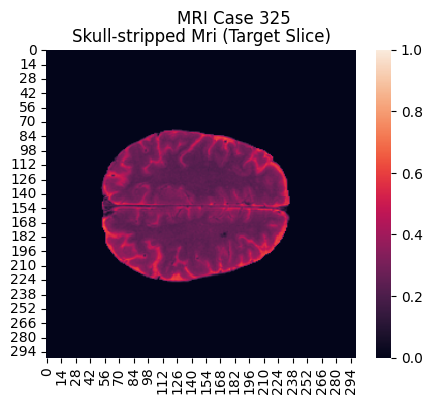

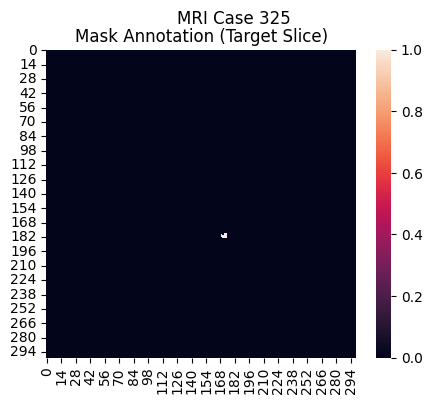

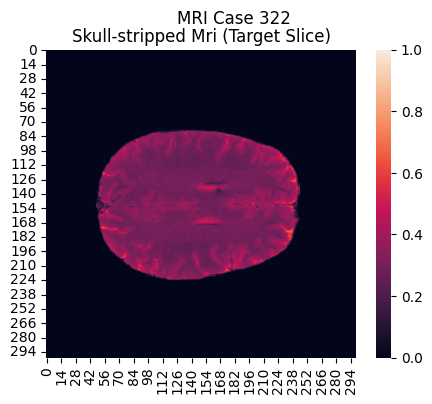

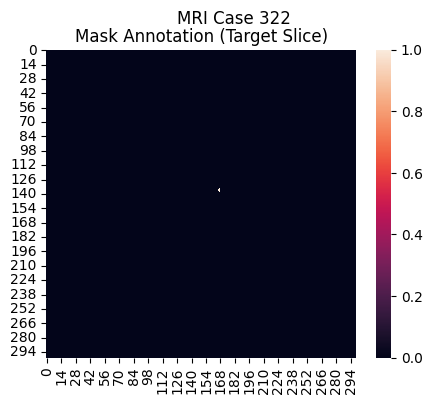

In [26]:
for batch in test_cases_dataset_stripped_dl:
    for slices, masks, target, case in batch:
        f, a = plt.subplots(1, 1, figsize=(5, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Skull-stripped Mri (Target Slice)')
        sns.heatmap(slices[target].squeeze(), ax=a, vmax=1)

        f, a = plt.subplots(1, 1, figsize=(5, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Mask Annotation (Target Slice)')
        sns.heatmap(masks[target].squeeze(), ax=a, vmax=1)

In [27]:
def make_feedset(
        data,
        target_shape=(300, 300),
        rpn_mode=True,
        logger=None
    ):
    s = f'Creating feedset\n'
    paths = data.stripped.unique().tolist()
    s += f'Total Unique MRI Samples in data_train: {len(paths)}\n'
    
    global_min, global_max = compute_statistics(paths)
    s += f'GLOBAL MIN & MAX {global_min, global_max}\n'
    global_min, global_max = compute_statistics(paths)
    
    feedset_transform = NiftiToTensorTransform(
        target_shape=target_shape,
        rpn_mode=rpn_mode,
        normalization=(global_min, global_max)
    )
    feedset = VALDODataset(
    cases=data.stripped,
    masks=data.masks,
    target=data.target,
    transform=feedset_transform
    )
    print(s)
    return feedset

In [28]:
feedset = make_feedset(
    data=test_cases,
    rpn_mode=True,
    target_shape=(300, 300)
)

Creating feedset
Total Unique MRI Samples in data_train: 4
GLOBAL MIN & MAX (0.0, 1011.271240234375)



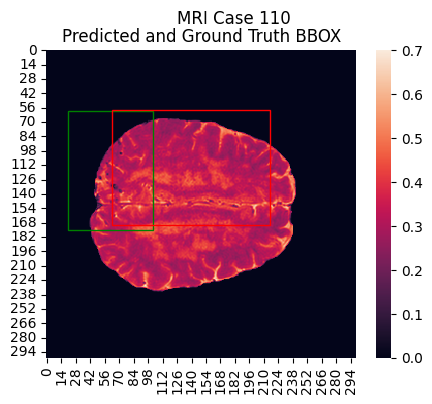

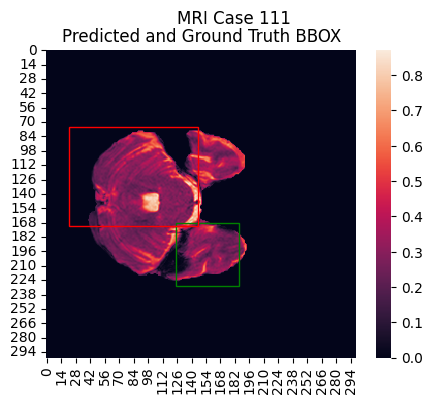

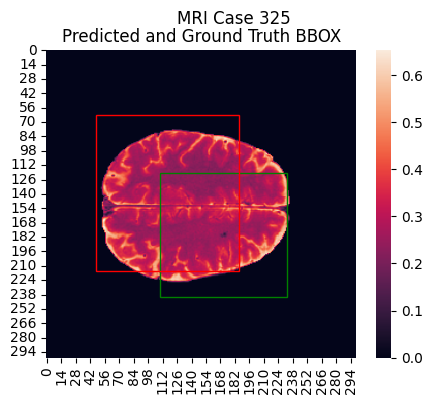

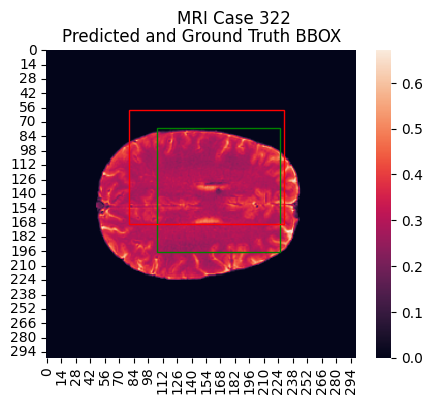

In [29]:
i = 0
for batch in test_cases_dataset_stripped_dl:
    for slices, masks, target, case in batch:
        try:
            predicted_bbox = bbox_predictions[i][0].detach().cpu()
        except:
            predicted_bbox = bbox_predictions[i]
        i += 1
        regions = feedset.locate_case_by_mri(case)
        bboxes = regions[1].view(regions[1].shape[0], -1)
        ground_truth_bbox = bboxes[target].round().int().tolist()
        
        f, a = plt.subplots(1, 1, figsize=(5, 4))

        truth = patches.Rectangle(
            (ground_truth_bbox[0], ground_truth_bbox[1]),
            ground_truth_bbox[2] - ground_truth_bbox[0],
            ground_truth_bbox[3] - ground_truth_bbox[1],
            linewidth=1, edgecolor='g', facecolor='none'
        )
        pred = patches.Rectangle(
            (predicted_bbox[0], predicted_bbox[1]),
            predicted_bbox[2] - predicted_bbox[0],
            predicted_bbox[3] - predicted_bbox[1],
            linewidth=1, edgecolor='r', facecolor='none'
        )

        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Predicted and Ground Truth BBOX')
        
        a = sns.heatmap(slices[target].squeeze().cpu())

        a.add_patch(truth)
        a.add_patch(pred)

In [30]:
def crop(bbox, img):
    try:
        bbox = bbox.round().int()
        x, y, w, h = bbox[0]
    except:
        x, y, w, h = bbox
    
    shape = img.shape

    x_min = min(x, w)
    x_max = max(x, w)
    y_min = min(y, h)
    y_max = max(y, h)

    # Reshape the image into 4 domensions
    img = img.view(shape[0], -1, shape[-2], shape[-1])

    for i in range(img.shape[0]):
        img_slice = img[i, 0]  # Extract the 2D slice (assuming single channel)
        cropped_slice = img_slice[y_min:y_max, x_min:x_max]
        height, width = cropped_slice.shape[:2]

        # Apply perfect square changes 
        if height > width:
            diff = height - width
            x_min = max(0, x_min - diff // 2) # Center the cmb
            x_max = min(img_slice.shape[1], x_max + diff // 2)
        elif width > height:
            diff = width - height
            y_min = max(0, y_min - diff // 2)  # Center the cmb
            y_max = min(img_slice.shape[0], y_max + diff // 2)

        # Re-crop to get the square
        cropped_slice = img_slice[y_min:y_max, x_min:x_max]
    return cropped_slice

### Cropped Target Slice without resizing

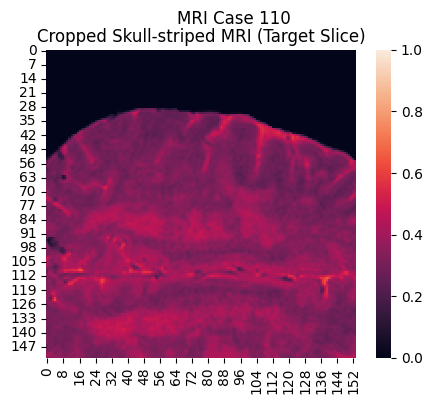

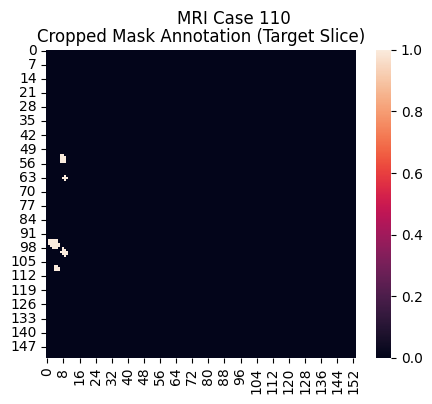

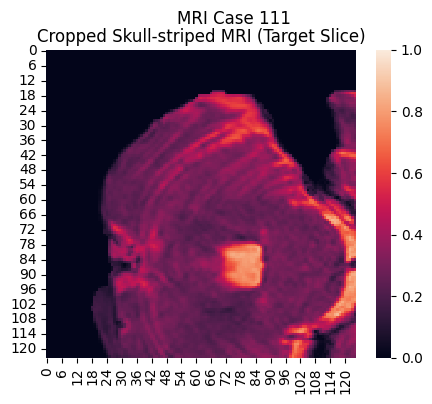

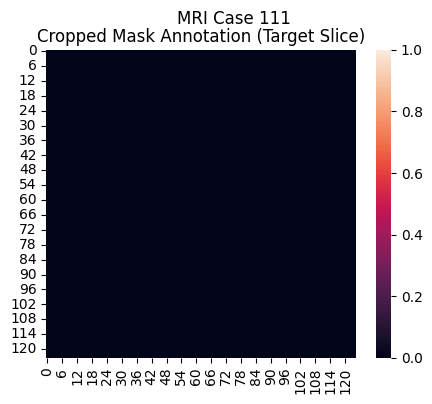

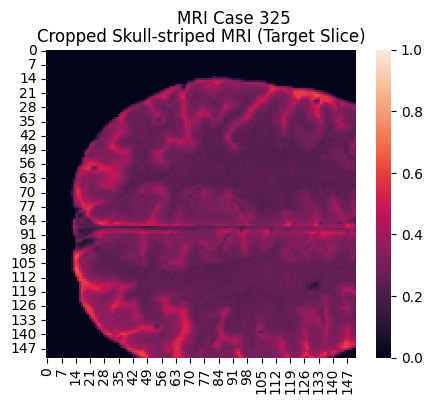

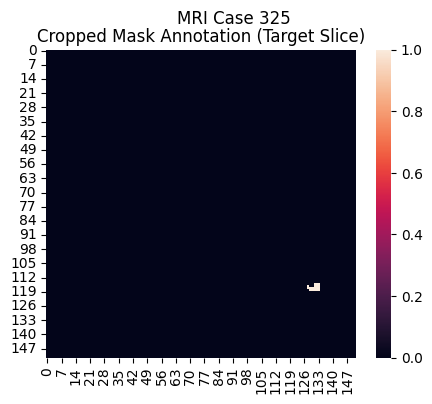

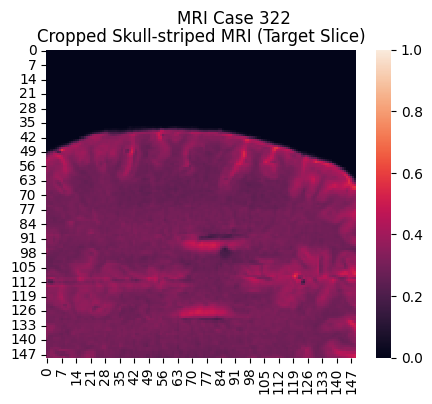

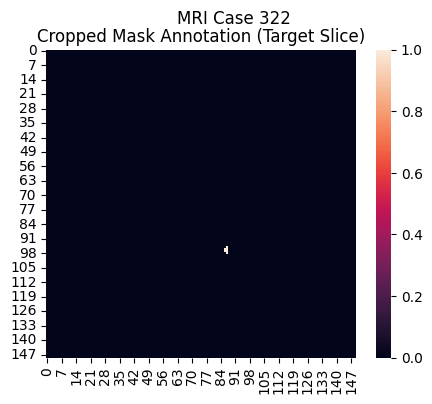

In [31]:
i = 0
for batch in test_cases_dataset_stripped_dl:
    for slices, masks, target, case in batch:

        cropped_slices = crop(bbox_predictions[i], slices[target])
        cropped_masks = crop(bbox_predictions[i], masks[target])
        i += 1

        f, a = plt.subplots(1, 1, figsize=(5, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Cropped Skull-striped MRI (Target Slice)')
        sns.heatmap(cropped_slices, ax=a, vmax=1)

        f, a = plt.subplots(1, 1, figsize=(5, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Cropped Mask Annotation (Target Slice)')
        sns.heatmap(cropped_masks, ax=a, vmax=1)

### Cropped Target slice for MRI and Mask Annotation

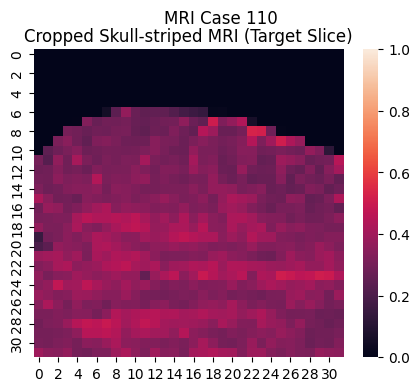

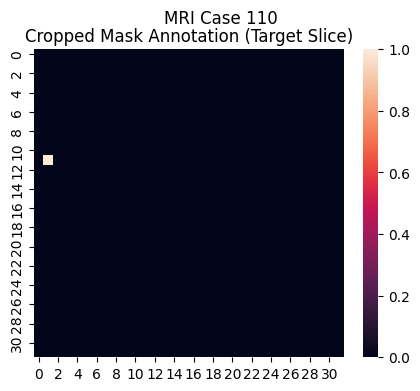

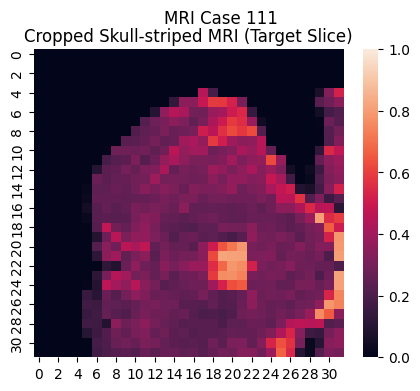

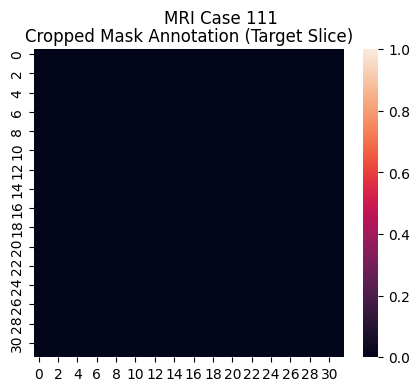

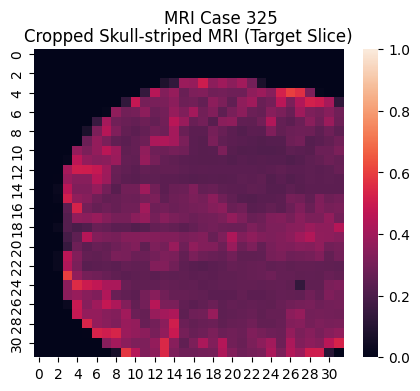

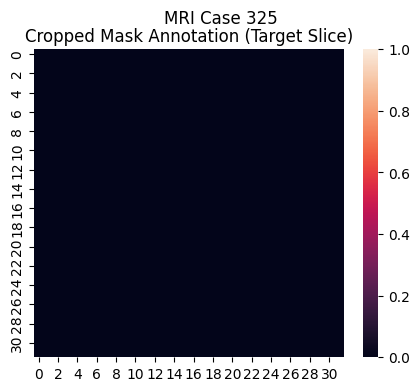

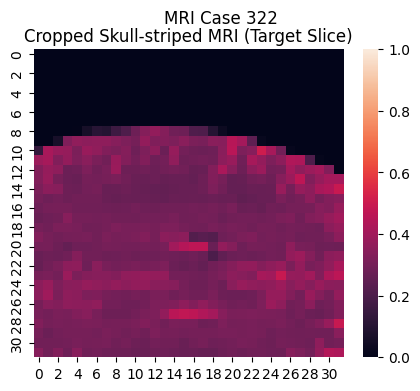

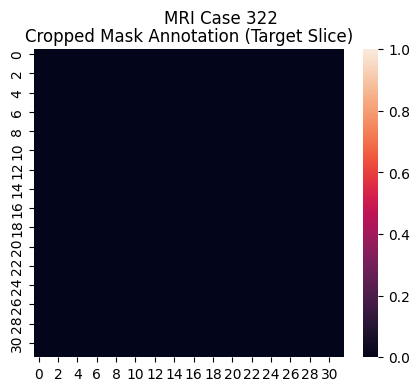

In [35]:
i = 0
for batch in test_cases_dataset_stripped_dl:
    for slices, masks, target, case in batch:
        try:
            cropped_slices = feeder(slices, bbox_predictions[i][0].round().int(), 32)
            cropped_masks = feeder(masks, bbox_predictions[i][0].round().int(), 32)
        except:
            cropped_slices = feeder(slices, bbox_predictions[i], 32)
            cropped_masks = feeder(masks, bbox_predictions[i], 32)
        i += 1
        
        f, a = plt.subplots(1, 1, figsize=(5, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Cropped Skull-striped MRI (Target Slice)')
        sns.heatmap(cropped_slices[target].squeeze(), ax=a, vmax=1)

        f, a = plt.subplots(1, 1, figsize=(5, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        a.set_title('Cropped Mask Annotation (Target Slice)')
        sns.heatmap(cropped_masks[target].squeeze(), ax=a, vmax=1)

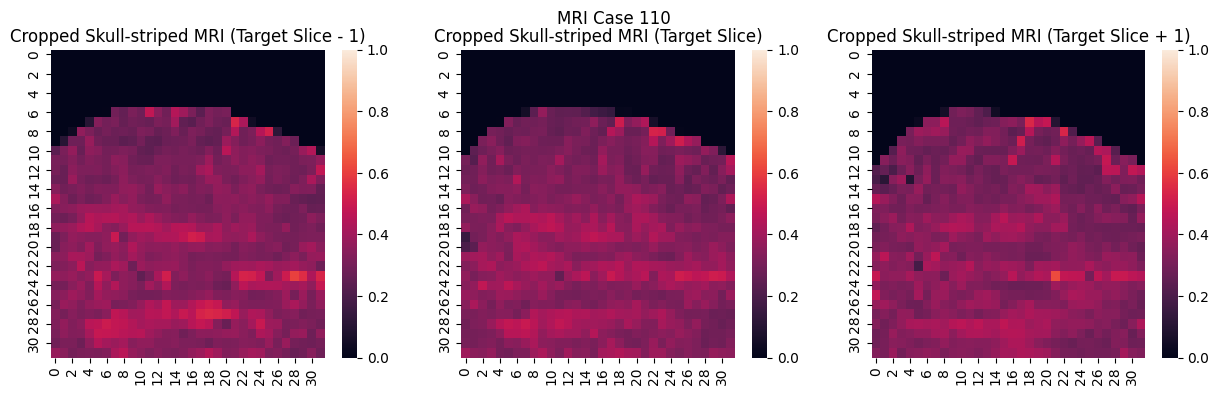

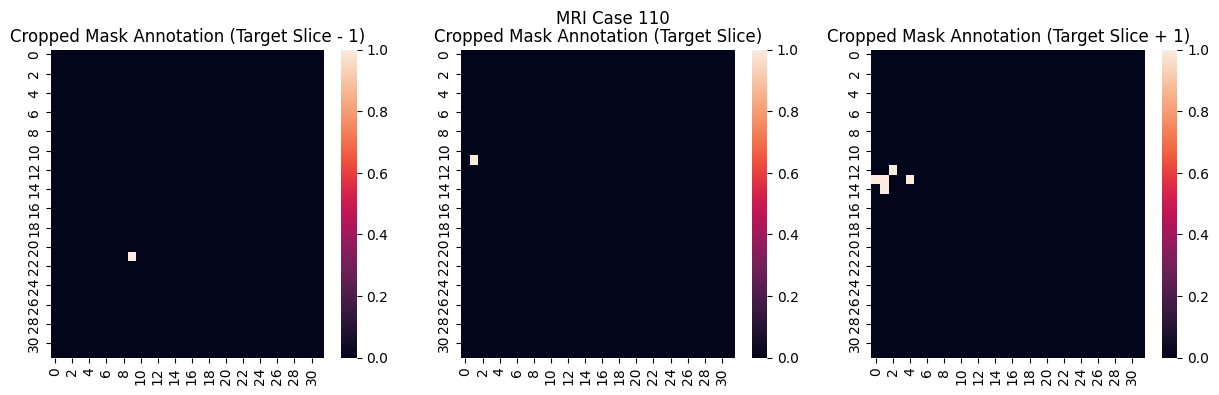

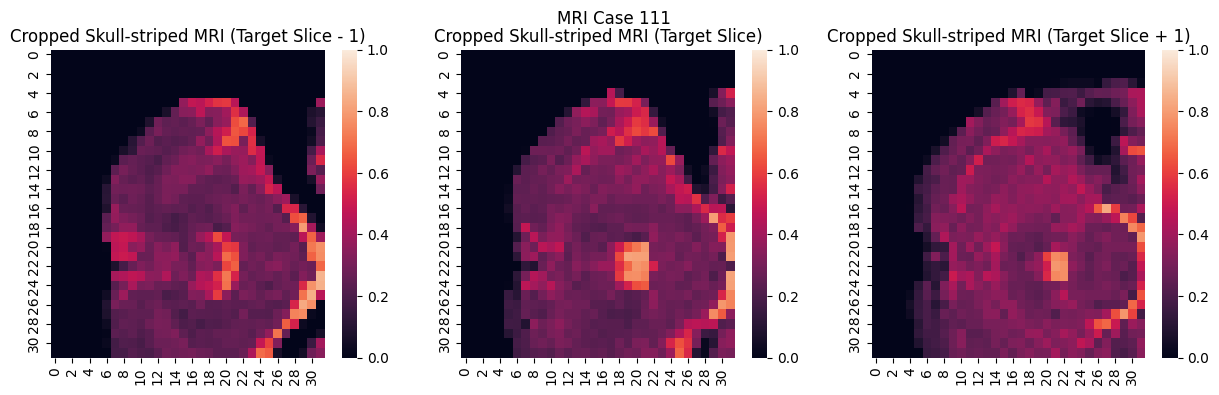

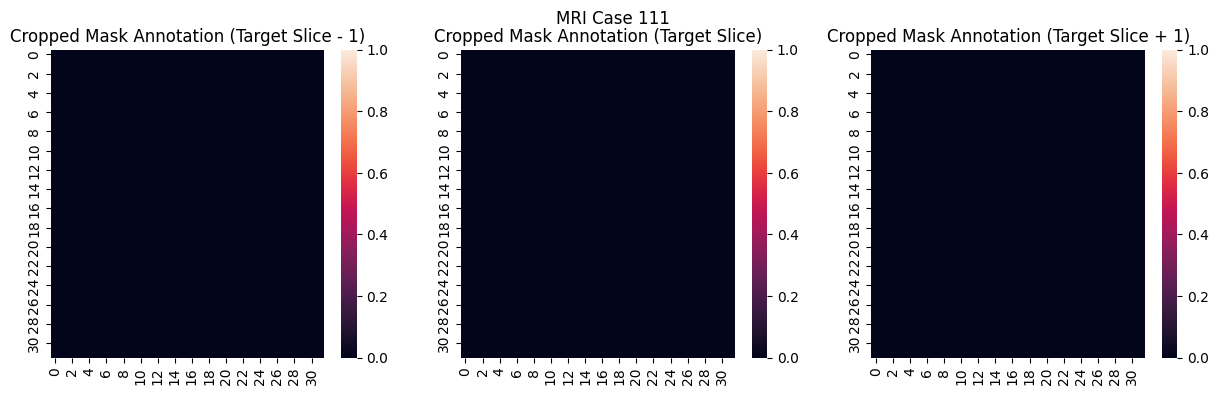

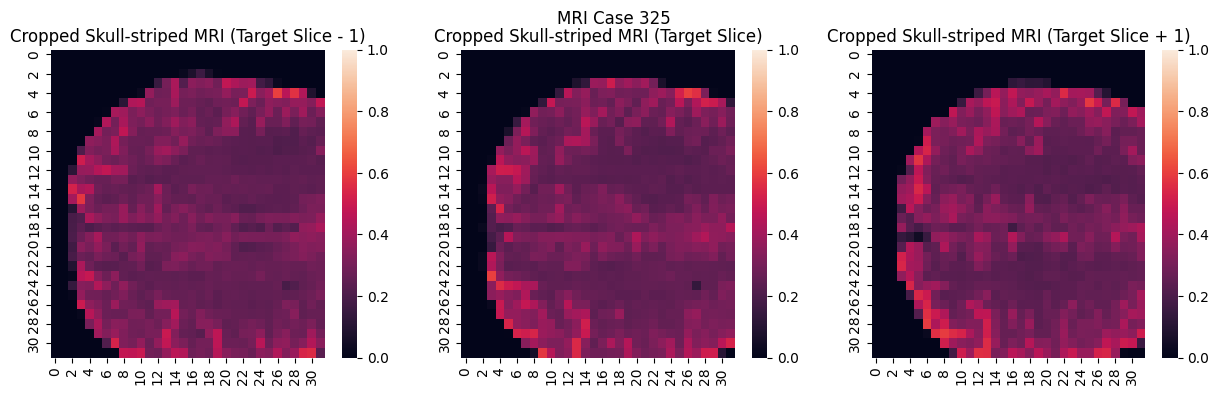

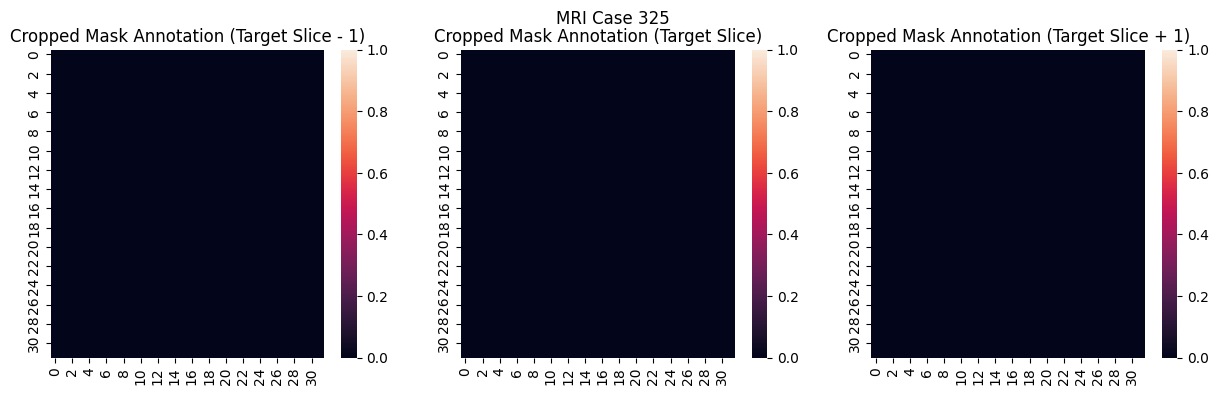

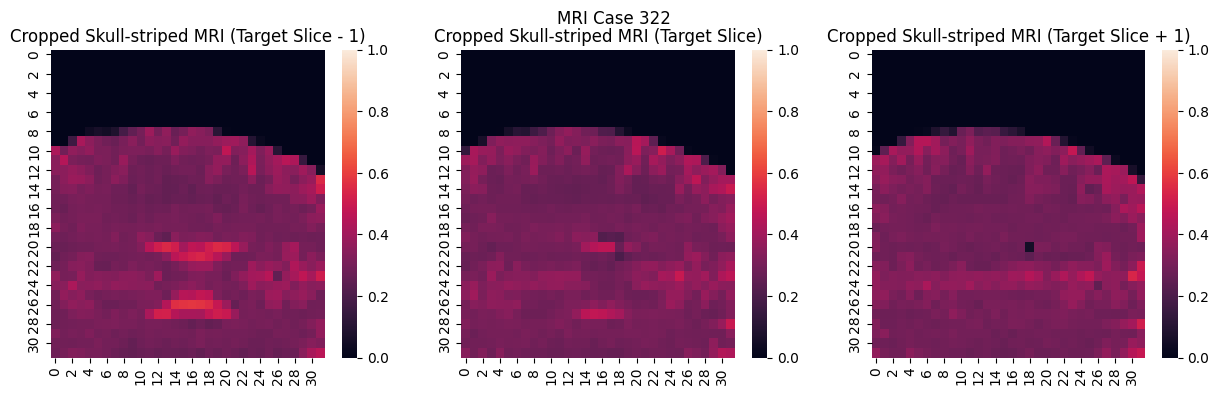

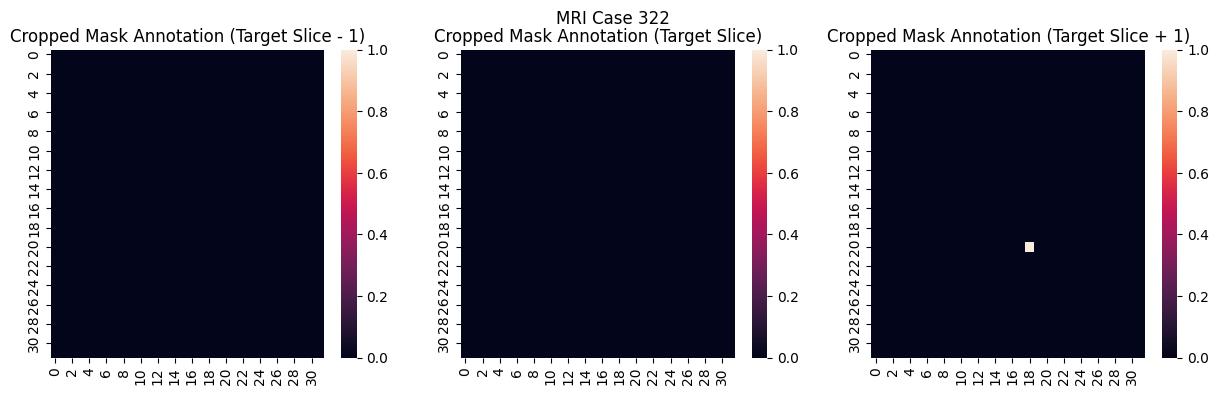

In [39]:
i = 0
for batch in test_cases_dataset_stripped_dl:
    for slices, masks, target, case in batch:
        try:
            cropped_slices = feeder(slices, bbox_predictions[i][0].round().int(), 32)
            cropped_masks = feeder(masks, bbox_predictions[i][0].round().int(), 32)
        except:
            cropped_slices = feeder(slices, bbox_predictions[i], 32)
            cropped_masks = feeder(masks, bbox_predictions[i], 32)
        i += 1
        
        f, a = plt.subplots(1, 3, figsize=(15, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax3 = a.flat[2]
        ax1.set_title('Cropped Skull-striped MRI (Target Slice - 1)')
        ax2.set_title('Cropped Skull-striped MRI (Target Slice)')
        ax3.set_title('Cropped Skull-striped MRI (Target Slice + 1)')
        sns.heatmap(cropped_slices[target - 1].squeeze(), ax=ax1, vmax=1)
        sns.heatmap(cropped_slices[target].squeeze(), ax=ax2, vmax=1)
        sns.heatmap(cropped_slices[target + 1].squeeze(), ax=ax3, vmax=1)

        f, a = plt.subplots(1, 3, figsize=(15, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax3 = a.flat[2]
        ax1.set_title('Cropped Mask Annotation (Target Slice - 1)')
        ax2.set_title('Cropped Mask Annotation (Target Slice)')
        ax3.set_title('Cropped Mask Annotation (Target Slice + 1)')
        sns.heatmap(cropped_masks[target - 1].squeeze(), ax=ax1, vmax=1)
        sns.heatmap(cropped_masks[target].squeeze(), ax=ax2, vmax=1)
        sns.heatmap(cropped_masks[target + 1].squeeze(), ax=ax3, vmax=1)

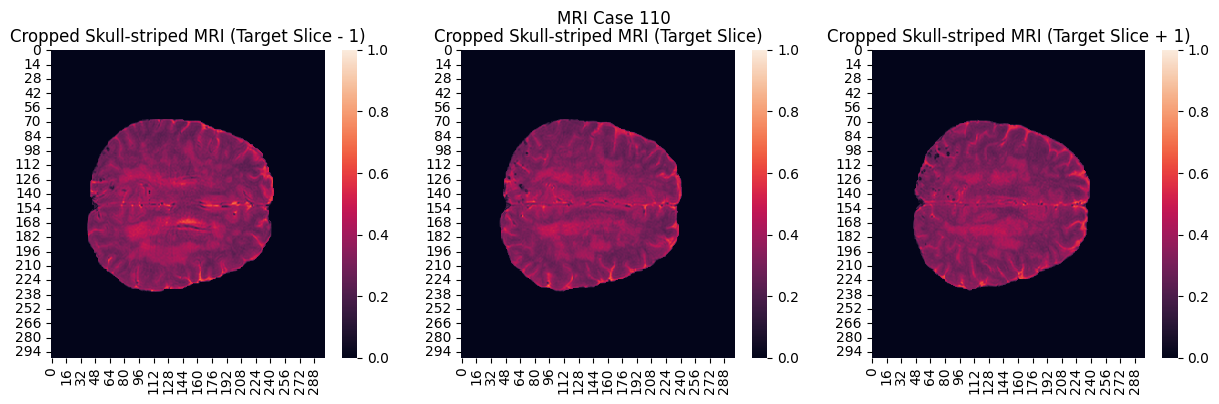

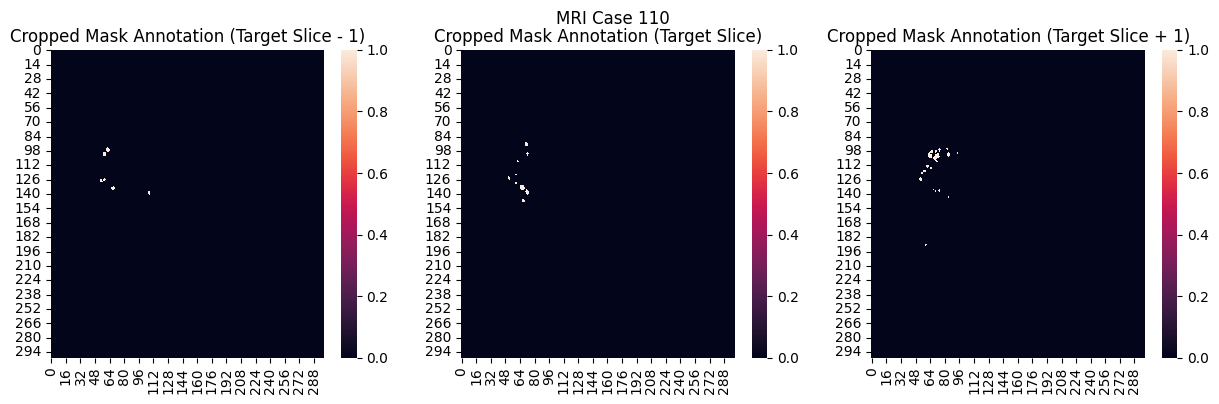

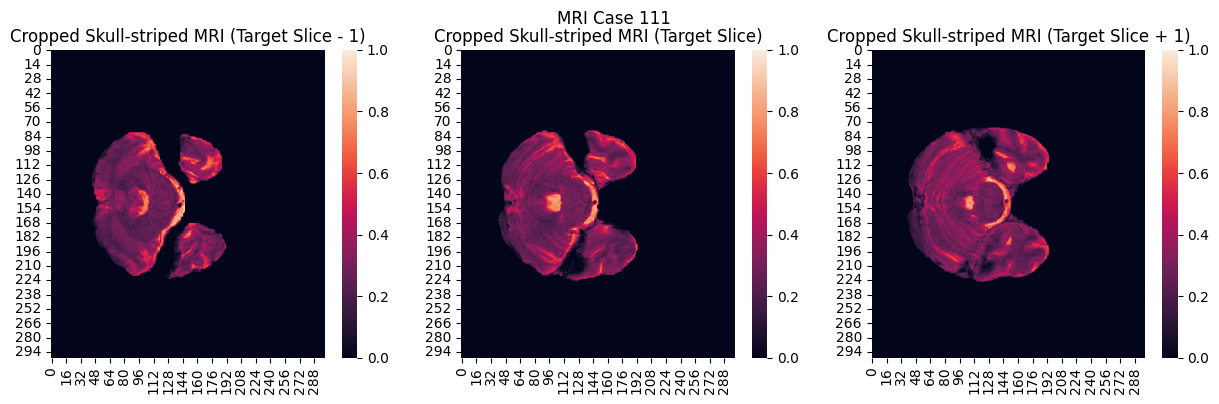

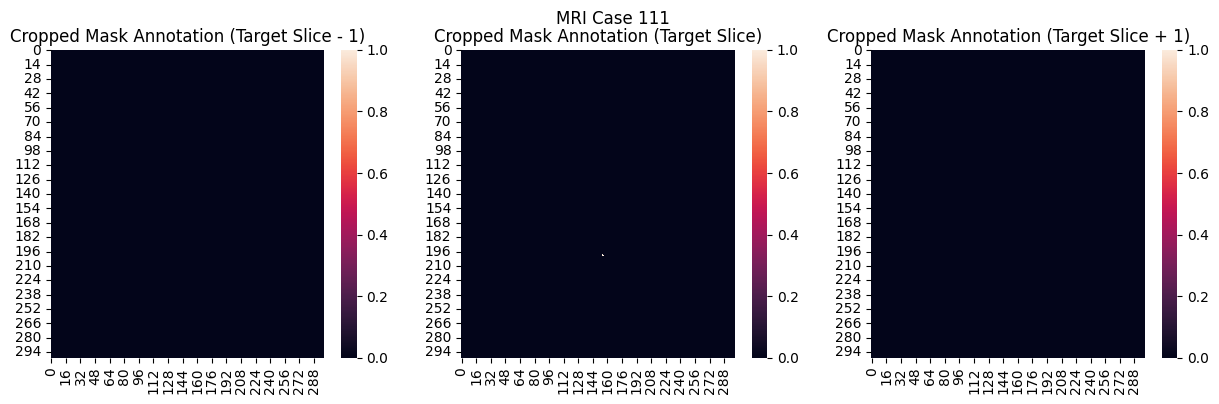

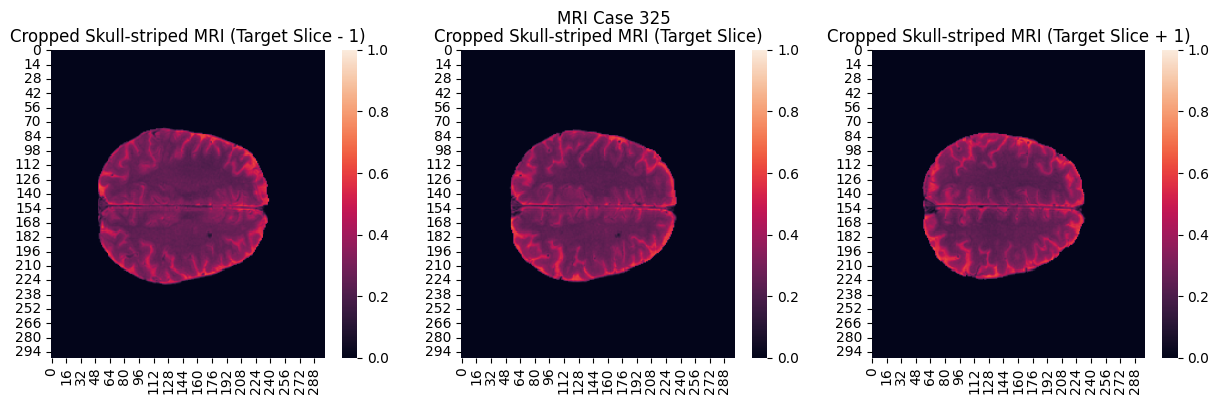

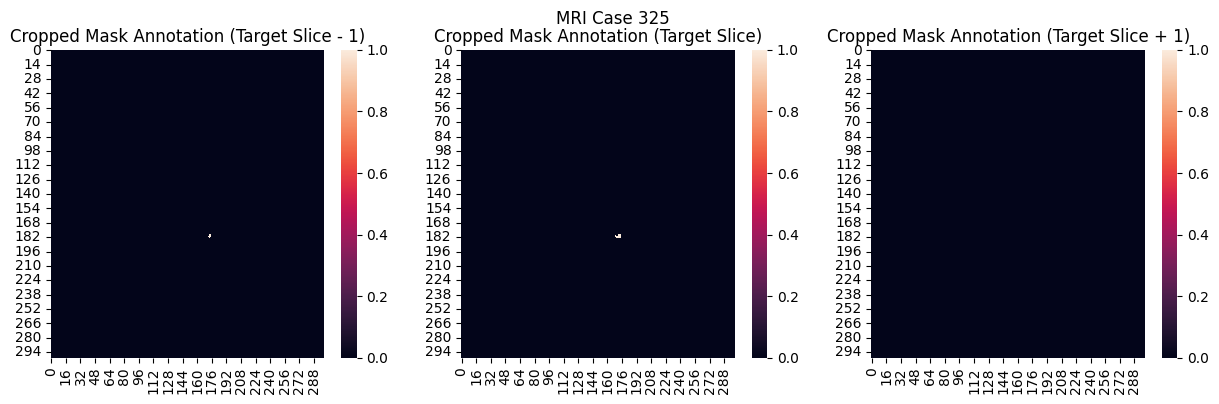

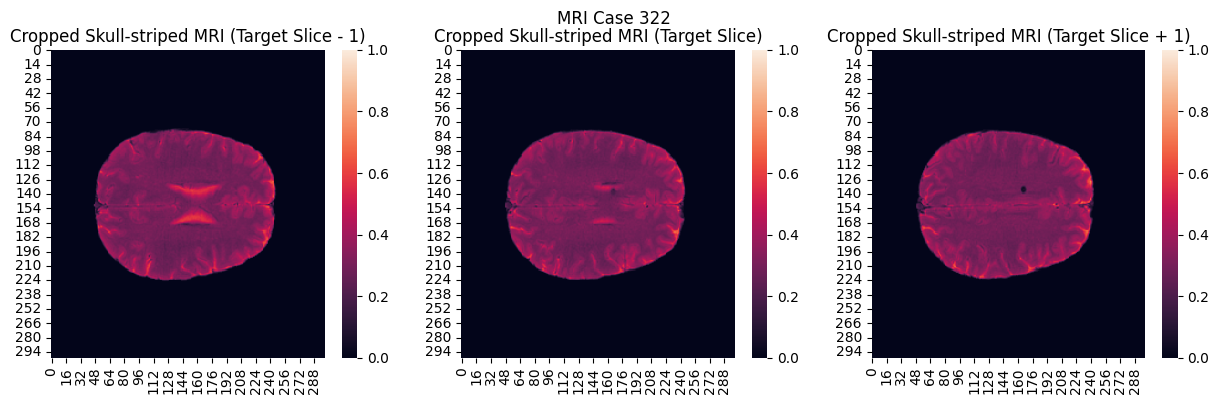

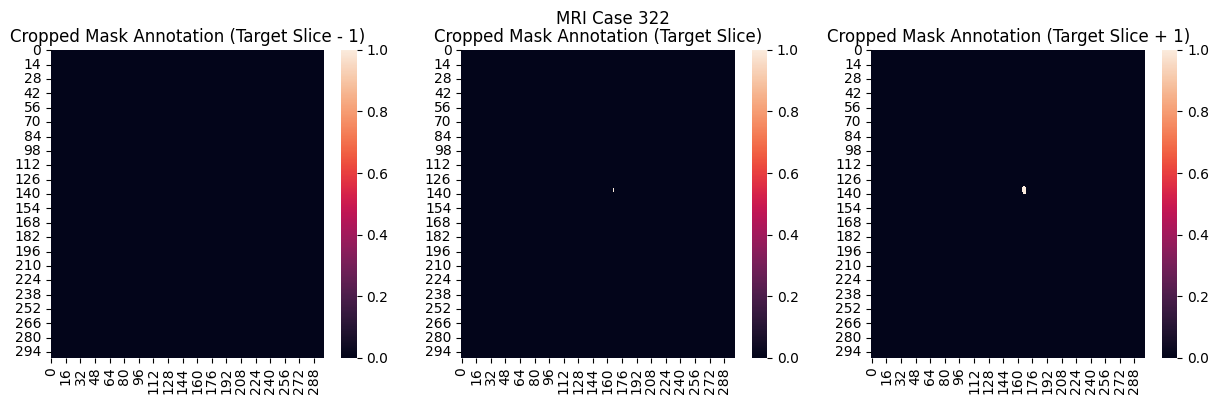

In [33]:
for batch in test_cases_dataset_stripped_dl:
    for slices, masks, target, case in batch:
        
        f, a = plt.subplots(1, 3, figsize=(15, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax3 = a.flat[2]
        ax1.set_title('Cropped Skull-striped MRI (Target Slice - 1)')
        ax2.set_title('Cropped Skull-striped MRI (Target Slice)')
        ax3.set_title('Cropped Skull-striped MRI (Target Slice + 1)')
        sns.heatmap(slices[target - 1].squeeze(), ax=ax1, vmax=1)
        sns.heatmap(slices[target].squeeze(), ax=ax2, vmax=1)
        sns.heatmap(slices[target + 1].squeeze(), ax=ax3, vmax=1)

        f, a = plt.subplots(1, 3, figsize=(15, 4))
        f.suptitle(f"MRI Case {case.split('\\')[-1].split('_')[0][-3:]}")
        ax1 = a.flat[0]
        ax2 = a.flat[1]
        ax3 = a.flat[2]
        ax1.set_title('Cropped Mask Annotation (Target Slice - 1)')
        ax2.set_title('Cropped Mask Annotation (Target Slice)')
        ax3.set_title('Cropped Mask Annotation (Target Slice + 1)')
        sns.heatmap(masks[target - 1].squeeze(), ax=ax1, vmax=1)
        sns.heatmap(masks[target].squeeze(), ax=ax2, vmax=1)
        sns.heatmap(masks[target + 1].squeeze(), ax=ax3, vmax=1)

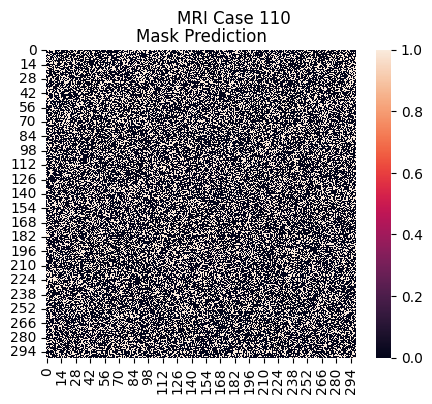

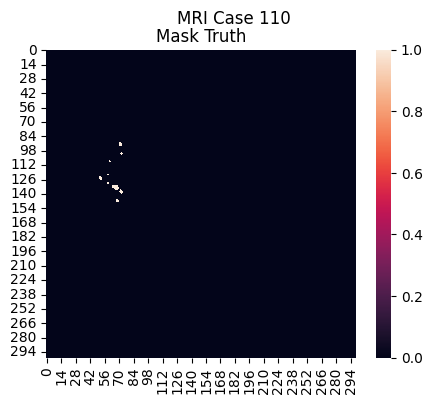

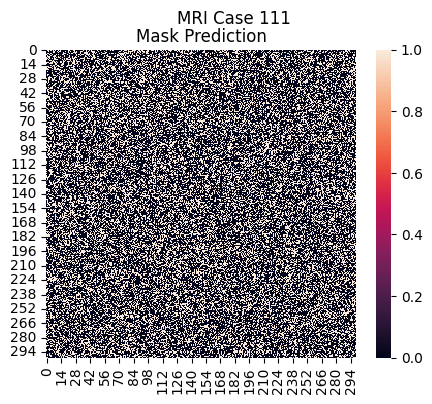

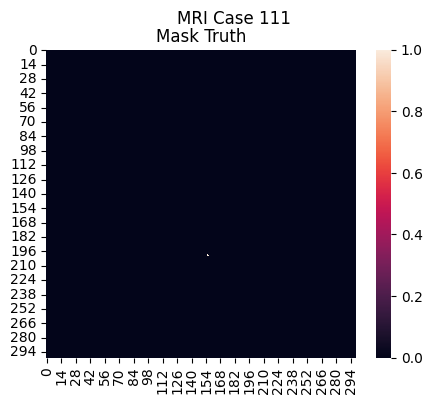

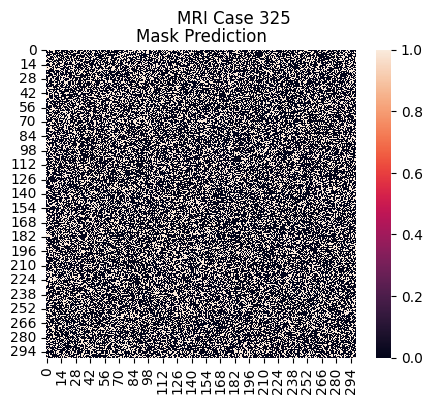

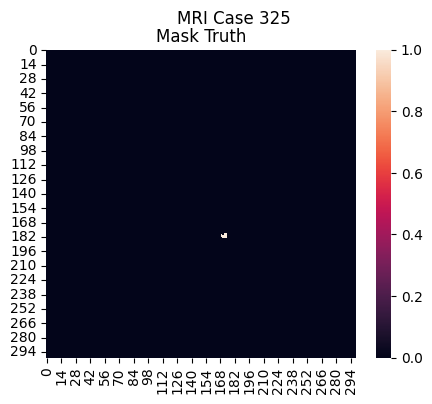

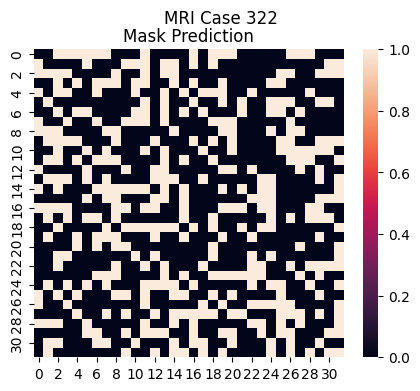

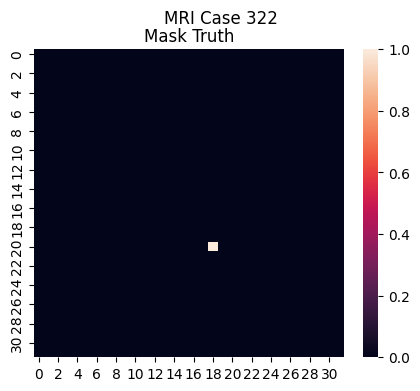

In [38]:
for i in range(4):
    # Prediction and ground truth plotting

    if predictions[i].shape[-1] == 1024:
        prediction = predictions[i].view(patch_size, patch_size).sigmoid().detach().cpu()
        ground_truth = ground_truths[i].view(patch_size, patch_size).detach().cpu()
    else:
        prediction = predictions[i].view(300, 300).sigmoid().detach().cpu()
        ground_truth = ground_truths[i].view(300, 300).detach().cpu()
    f, a = plt.subplots(1, 1, figsize=(5, 4))
    f.suptitle(f"MRI Case {test_cases['mri'].loc[i].split('\\')[-1].split('_')[0][-3:]}")
    a.set_title('Mask Prediction')
    sns.heatmap((prediction > 0.5), ax=a, vmax=1)

    f, a = plt.subplots(1, 1, figsize=(5, 4))
    f.suptitle(f"MRI Case {test_cases['mri'].loc[i].split('\\')[-1].split('_')[0][-3:]}")
    a.set_title('Mask Truth')
    sns.heatmap((ground_truth > 0), ax=a, vmax=1)